# TF Cascade

In [69]:
import torchvision
import torch
import pandas as pd
import numpy as np
from torchvision import transforms
from PIL import Image
import os

data_folder_path = '/home/cc/object-store/datasets'
dataset_folder_path = os.path.join(
    data_folder_path, 'ILSVRC/Data/DET/test'
)
classes_file_path = os.path.join(
    data_folder_path, 'imagenet_classes.txt'
)

In [70]:
with open(classes_file_path) as f:
    classes = [line.strip() for line in f.readlines()]

x = np.array([])
directory = os.fsencode(dataset_folder_path)

for root, dirs, files in os.walk(dataset_folder_path):
    for filename in files:
        x = np.append(x, filename)
df = pd.DataFrame(data=x, columns=["images"])
df['images'][0]

'ILSVRC2017_test_00005500.JPEG'

In [71]:
def resnet_model(img):
    """
    ResNet101 for image classification on ResNet
    """
    # standard resnet image transformation
    transform = transforms.Compose([
    transforms.Resize(256),                    
    transforms.CenterCrop(224), 
    transforms.ToTensor(),                     
    transforms.Normalize(                      
    mean=[0.485, 0.456, 0.406],                
    std=[0.229, 0.224, 0.225]                  
    )])
    
    resnet = torchvision.models.resnet101(pretrained=True)
    resnet.eval()
    # img_2 = Image.open(os.path.join(dataset_folder, img[0]))
    img_t = transform(img['images'])
    batch_t = torch.unsqueeze(img_t, 0)
    out = resnet(batch_t)
    _, indices = torch.sort(out, descending=True)
    percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
    p_2 = percentage.detach().numpy()
    return indices.detach().numpy()[0], p_2, p_2[indices[0][0]]


In [72]:
def inceptionv3_model(img):
    transform = transforms.Compose([
    transforms.Resize(256),                    
    transforms.CenterCrop(224),                
    transforms.ToTensor(),                     
    transforms.Normalize(                      
    mean=[0.485, 0.456, 0.406],                
    std=[0.229, 0.224, 0.225]                  
    )])
    
    resnet = torchvision.models.inception_v3(pretrained=True)
    resnet.eval()
    # img_2 = Image.open(os.path.join(dataset_folder, img[0]))
    img_t = transform(img['images'])
    batch_t = torch.unsqueeze(img_t, 0)
    out = resnet(batch_t)
    _, indices = torch.sort(out, descending=True)
    percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
    p_2 = percentage.detach().numpy()
    return indices.detach().numpy()[0], p_2, p_2[indices[0][0]]

In [73]:
def cascade_predict(row):
    """
    cascade predict based on resnt and compare the final results
    """
    r_index = row[1]
    r_perc = row[2]
    r_max_prob = row[3]
    i_index = row[4]
    i_perc = row[5]
    i_max_prob= row[6]
#     print(np.isnan(i_max_prob))
    
    if np.isnan(i_max_prob):
        # didn't go to inception because resnet prediction was confident enough
        return r_index, r_perc, classes[r_index[0]]
    else:
        #choose the distribution with the higher max_prob
        if r_max_prob > i_max_prob:
            return r_index, r_perc, classes[r_index[0]]
        else:
            return i_index, i_perc, classes[i_index[0]]


In [74]:
def filter_color_images(img):
    img_2 = Image.open(os.path.join(dataset_folder_path, img[0]))
    if img_2.mode == 'RGB':
        return True
    return False

In [75]:
def show(img):
    img_2 = Image.open(os.path.join(dataset_folder_path, img))
    img_2.show()

def load_pics(img):
    img = Image.open(os.path.join(dataset_folder_path, img))
    return img

In [76]:
num_images = 10
# client side preprocess
df = df.sort_values(by=['images'])
# df['image_names'] = df['images']
df_s = df.head(num_images)
df_s = df_s[df_s.apply(filter_color_images, axis=1)]
df_s['images'] = df_s['images'].apply(load_pics)

In [77]:
img_index = 0
res = resnet_model(df_s.iloc[img_index])
res

(array([291, 286, 290, 288, 285, 179, 180, 281, 245, 282, 243, 294, 292,
        295, 349,  51, 354, 289, 708, 385, 242, 350, 246, 195, 273, 276,
        159, 805, 264, 348, 209, 649, 345, 296, 253, 234, 163, 293, 150,
        101, 274, 219, 676, 260, 240, 287, 340, 106, 971, 562, 682, 873,
        386, 417, 238, 227, 360, 832, 208, 220, 341, 850, 347, 342, 515,
        244, 256, 718, 343, 206, 976, 151, 852, 213, 339, 269, 275, 207,
        885, 458, 161, 426, 186, 857, 197, 263, 267, 577, 185, 652, 211,
        698, 232, 241, 557, 972, 755, 517, 373, 420, 835, 344, 958, 865,
        494, 239, 716, 168, 900, 236, 442, 750, 858, 489, 545, 818, 728,
        727, 189, 218, 980, 978, 421, 497, 884, 663, 172, 610, 538, 297,
        491, 272, 875, 975, 568, 184, 912, 514, 768, 355, 112, 191, 216,
        346, 248, 262, 283, 799, 775, 437, 178, 656, 880, 214, 839, 247,
         39,  23, 119, 457, 539, 776, 808, 250, 221, 235, 351, 819, 356,
        254, 911, 872, 594, 841, 566, 205, 486, 903

In [78]:
resnet_preds = df_s.apply(
    resnet_model, axis=1, result_type="expand").rename(
        columns={0: "resnet_indices", 1: "resnet_percentage", 2: "resnet_max_prob"})
resnet_preds

,resnet_indices,resnet_percentage,resnet_max_prob
5499,"[291, 286, 290, 288, 285, 179, 180, 281, 245, ...","[2.3939569e-05, 2.8939736e-05, 0.00059994013, ...",57.083775
5498,"[655, 459, 831, 838, 721, 631, 774, 638, 697, ...","[2.1473083e-05, 3.8140526e-05, 2.873827e-05, 5...",42.014565
5497,"[741, 982, 406, 399, 606, 854, 887, 564, 501, ...","[7.300405e-05, 0.00033378694, 0.00042195024, 7...",25.989595
5496,"[1, 392, 0, 397, 393, 395, 973, 126, 389, 29, ...","[0.02528877, 99.641975, 2.4654378e-06, 5.13774...",99.641975
5495,"[867, 569, 803, 595, 517, 864, 561, 866, 856, ...","[1.4286863e-05, 2.0474825e-05, 8.140727e-06, 5...",89.045372
5494,"[990, 957, 989, 301, 641, 952, 588, 954, 936, ...","[0.00033662192, 0.0042422055, 5.917899e-05, 3....",65.406738
5493,"[40, 44, 42, 46, 41, 38, 43, 26, 47, 59, 31, 6...","[3.8624592e-07, 1.5614083e-07, 3.843858e-07, 4...",74.409271
5492,"[459, 823, 711, 605, 837, 487, 785, 523, 836, ...","[0.0001199595, 0.0015492699, 0.007063576, 0.00...",10.448801
5491,"[546, 402, 819, 420, 650, 776, 641, 401, 699, ...","[2.1321055e-07, 8.5746547e-07, 9.613609e-06, 2...",42.947746
5490,"[83, 135, 85, 82, 21, 86, 80, 91, 8, 94, 7, 81...","[0.00011233683, 0.0006620713, 0.00027617192, 4...",15.803986


In [79]:
resnet_preds = df_s.apply(
    resnet_model, axis=1, result_type="expand").rename(
        columns={0: "resnet_indices", 1: "resnet_percentage", 2: "resnet_max_prob"}) 

# only send the queries that are above a 85 percnt to the resnet model
# then join it with the original 
inception_preds = df_s.join(
    resnet_preds[resnet_preds['resnet_max_prob'] < 85], how='right').apply(
        inceptionv3_model, axis=1, result_type="expand").rename(
            columns={0: "inception_indices", 1: "inception_percentage", 2:"inception_max_prob"})
inception_preds

,inception_indices,inception_percentage,inception_max_prob
5499,"[286, 294, 291, 290, 295, 276, 293, 285, 274, ...","[2.0862842e-06, 3.295849e-06, 9.911781e-07, 4....",79.452255
5498,"[655, 459, 445, 638, 774, 747, 788, 831, 806, ...","[2.6346274e-07, 6.848853e-07, 4.587085e-06, 5....",82.410416
5497,"[203, 153, 915, 399, 741, 216, 854, 887, 155, ...","[0.000104486004, 0.0010278045, 0.0010109564, 0...",63.962521
5494,"[957, 954, 956, 990, 952, 953, 617, 923, 989, ...","[2.2259933e-08, 1.1770885e-08, 9.0618935e-09, ...",99.996307
5493,"[40, 59, 44, 94, 563, 46, 55, 317, 99, 52, 61,...","[1.5720163e-06, 6.5121617e-06, 7.4789896e-05, ...",63.711292
5492,"[433, 445, 667, 823, 400, 639, 793, 638, 774, ...","[0.00058228907, 0.001454541, 0.0015341156, 0.0...",37.594894
5491,"[402, 486, 546, 819, 650, 420, 593, 889, 699, ...","[5.2732703e-05, 6.141218e-05, 7.447234e-05, 6....",85.284012
5490,"[8, 85, 83, 141, 7, 140, 142, 135, 136, 93, 86...","[0.0005268304, 0.0043064733, 0.003402347, 0.00...",27.275921


In [80]:
resnet_preds = df_s.apply(
    resnet_model, axis=1, result_type="expand").rename(
        columns={0: "resnet_indices", 1: "resnet_percentage", 2: "resnet_max_prob"}) 

# only send the queries that are above a 85 percnt to the resnet model
# then join it with the original 
inception_preds = df_s.join(
    resnet_preds[resnet_preds['resnet_max_prob'] < 85], how='right').apply(
        inceptionv3_model, axis=1, result_type="expand").rename(
            columns={0: "inception_indices", 1: "inception_percentage", 2:"inception_max_prob"})

all_preds = df_s.join([resnet_preds, inception_preds])
all_preds 



,images,resnet_indices,resnet_percentage,resnet_max_prob,inception_indices,inception_percentage,inception_max_prob
5499,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[291, 286, 290, 288, 285, 179, 180, 281, 245, ...","[2.3939569e-05, 2.8939736e-05, 0.00059994013, ...",57.083775,"[286, 294, 291, 290, 295, 276, 293, 285, 274, ...","[2.0862842e-06, 3.295849e-06, 9.911781e-07, 4....",79.452255
5498,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[655, 459, 831, 838, 721, 631, 774, 638, 697, ...","[2.1473083e-05, 3.8140526e-05, 2.873827e-05, 5...",42.014565,"[655, 459, 445, 638, 774, 747, 788, 831, 806, ...","[2.6346274e-07, 6.848853e-07, 4.587085e-06, 5....",82.410416
5497,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[741, 982, 406, 399, 606, 854, 887, 564, 501, ...","[7.300405e-05, 0.00033378694, 0.00042195024, 7...",25.989595,"[203, 153, 915, 399, 741, 216, 854, 887, 155, ...","[0.000104486004, 0.0010278045, 0.0010109564, 0...",63.962521
5496,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[1, 392, 0, 397, 393, 395, 973, 126, 389, 29, ...","[0.02528877, 99.641975, 2.4654378e-06, 5.13774...",99.641975,NaN,NaN,NaN
5495,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[867, 569, 803, 595, 517, 864, 561, 866, 856, ...","[1.4286863e-05, 2.0474825e-05, 8.140727e-06, 5...",89.045372,NaN,NaN,NaN
5494,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[990, 957, 989, 301, 641, 952, 588, 954, 936, ...","[0.00033662192, 0.0042422055, 5.917899e-05, 3....",65.406738,"[957, 954, 956, 990, 952, 953, 617, 923, 989, ...","[2.2259933e-08, 1.1770885e-08, 9.0618935e-09, ...",99.996307
5493,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[40, 44, 42, 46, 41, 38, 43, 26, 47, 59, 31, 6...","[3.8624592e-07, 1.5614083e-07, 3.843858e-07, 4...",74.409271,"[40, 59, 44, 94, 563, 46, 55, 317, 99, 52, 61,...","[1.5720163e-06, 6.5121617e-06, 7.4789896e-05, ...",63.711292
5492,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[459, 823, 711, 605, 837, 487, 785, 523, 836, ...","[0.0001199595, 0.0015492699, 0.007063576, 0.00...",10.448801,"[433, 445, 667, 823, 400, 639, 793, 638, 774, ...","[0.00058228907, 0.001454541, 0.0015341156, 0.0...",37.594894
5491,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[546, 402, 819, 420, 650, 776, 641, 401, 699, ...","[2.1321055e-07, 8.5746547e-07, 9.613609e-06, 2...",42.947746,"[402, 486, 546, 819, 650, 420, 593, 889, 699, ...","[5.2732703e-05, 6.141218e-05, 7.447234e-05, 6....",85.284012
5490,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[83, 135, 85, 82, 21, 86, 80, 91, 8, 94, 7, 81...","[0.00011233683, 0.0006620713, 0.00027617192, 4...",15.803986,"[8, 85, 83, 141, 7, 140, 142, 135, 136, 93, 86...","[0.0005268304, 0.0043064733, 0.003402347, 0.00...",27.275921


In [81]:
# Calling the cascading function
cascade_df = all_preds.join(
    all_preds.apply(
        cascade_predict, axis=1, result_type="expand").rename(
            columns={0: "cascade_indices", 1: "cascade_percentage", 2:"cascade_prediction"}))
cascade_df


,images,resnet_indices,resnet_percentage,resnet_max_prob,inception_indices,inception_percentage,inception_max_prob,cascade_indices,cascade_percentage,cascade_prediction
5499,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[291, 286, 290, 288, 285, 179, 180, 281, 245, ...","[2.3939569e-05, 2.8939736e-05, 0.00059994013, ...",57.083775,"[286, 294, 291, 290, 295, 276, 293, 285, 274, ...","[2.0862842e-06, 3.295849e-06, 9.911781e-07, 4....",79.452255,"[286, 294, 291, 290, 295, 276, 293, 285, 274, ...","[2.0862842e-06, 3.295849e-06, 9.911781e-07, 4....",cougar
5498,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[655, 459, 831, 838, 721, 631, 774, 638, 697, ...","[2.1473083e-05, 3.8140526e-05, 2.873827e-05, 5...",42.014565,"[655, 459, 445, 638, 774, 747, 788, 831, 806, ...","[2.6346274e-07, 6.848853e-07, 4.587085e-06, 5....",82.410416,"[655, 459, 445, 638, 774, 747, 788, 831, 806, ...","[2.6346274e-07, 6.848853e-07, 4.587085e-06, 5....",miniskirt
5497,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[741, 982, 406, 399, 606, 854, 887, 564, 501, ...","[7.300405e-05, 0.00033378694, 0.00042195024, 7...",25.989595,"[203, 153, 915, 399, 741, 216, 854, 887, 155, ...","[0.000104486004, 0.0010278045, 0.0010109564, 0...",63.962521,"[203, 153, 915, 399, 741, 216, 854, 887, 155, ...","[0.000104486004, 0.0010278045, 0.0010109564, 0...",West_Highland_white_terrier
5496,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[1, 392, 0, 397, 393, 395, 973, 126, 389, 29, ...","[0.02528877, 99.641975, 2.4654378e-06, 5.13774...",99.641975,NaN,NaN,NaN,"[1, 392, 0, 397, 393, 395, 973, 126, 389, 29, ...","[0.02528877, 99.641975, 2.4654378e-06, 5.13774...",goldfish
5495,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[867, 569, 803, 595, 517, 864, 561, 866, 856, ...","[1.4286863e-05, 2.0474825e-05, 8.140727e-06, 5...",89.045372,NaN,NaN,NaN,"[867, 569, 803, 595, 517, 864, 561, 866, 856, ...","[1.4286863e-05, 2.0474825e-05, 8.140727e-06, 5...",trailer_truck
5494,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[990, 957, 989, 301, 641, 952, 588, 954, 936, ...","[0.00033662192, 0.0042422055, 5.917899e-05, 3....",65.406738,"[957, 954, 956, 990, 952, 953, 617, 923, 989, ...","[2.2259933e-08, 1.1770885e-08, 9.0618935e-09, ...",99.996307,"[957, 954, 956, 990, 952, 953, 617, 923, 989, ...","[2.2259933e-08, 1.1770885e-08, 9.0618935e-09, ...",pomegranate
5493,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[40, 44, 42, 46, 41, 38, 43, 26, 47, 59, 31, 6...","[3.8624592e-07, 1.5614083e-07, 3.843858e-07, 4...",74.409271,"[40, 59, 44, 94, 563, 46, 55, 317, 99, 52, 61,...","[1.5720163e-06, 6.5121617e-06, 7.4789896e-05, ...",63.711292,"[40, 44, 42, 46, 41, 38, 43, 26, 47, 59, 31, 6...","[3.8624592e-07, 1.5614083e-07, 3.843858e-07, 4...",American_chameleon
5492,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[459, 823, 711, 605, 837, 487, 785, 523, 836, ...","[0.0001199595, 0.0015492699, 0.007063576, 0.00...",10.448801,"[433, 445, 667, 823, 400, 639, 793, 638, 774, ...","[0.00058228907, 0.001454541, 0.0015341156, 0.0...",37.594894,"[433, 445, 667, 823, 400, 639, 793, 638, 774, ...","[0.00058228907, 0.001454541, 0.0015341156, 0.0...",bathing_cap
5491,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[546, 402, 819, 420, 650, 776, 641, 401, 699, ...","[2.1321055e-07, 8.5746547e-07, 9.613609e-06, 2...",42.947746,"[402, 486, 546, 819, 650, 420, 593, 889, 699, ...","[5.2732703e-05, 6.141218e-05, 7.447234e-05, 6....",85.284012,"[402, 486, 546, 819, 650, 420, 593, 889, 699, ...","[5.2732703e-05, 6.141218e-05, 7.447234e-05, 6....",acoustic_guitar
5490,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[83, 135, 85, 82, 21, 86, 80, 91, 8, 94, 7, 81...","[0.00011233683, 0.0006620713, 0.00027617192, 4...",15.803986,"[8, 85, 83, 141, 7, 140, 142, 135, 136, 93, 86...","[0.0005268304, 0.0043064733, 0.003402347, 0.00...",27.275921,"[8, 85, 83, 141, 7, 140, 142, 135, 136, 93, 86...","[0.0005268304, 0.0043064733, 0.003402347, 0.00...",hen


In [82]:
cascade_df[['images', 'cascade_prediction']]

,images,cascade_prediction
5499,<PIL.JpegImagePlugin.JpegImageFile image mode=...,cougar
5498,<PIL.JpegImagePlugin.JpegImageFile image mode=...,miniskirt
5497,<PIL.JpegImagePlugin.JpegImageFile image mode=...,West_Highland_white_terrier
5496,<PIL.JpegImagePlugin.JpegImageFile image mode=...,goldfish
5495,<PIL.JpegImagePlugin.JpegImageFile image mode=...,trailer_truck
5494,<PIL.JpegImagePlugin.JpegImageFile image mode=...,pomegranate
5493,<PIL.JpegImagePlugin.JpegImageFile image mode=...,American_chameleon
5492,<PIL.JpegImagePlugin.JpegImageFile image mode=...,bathing_cap
5491,<PIL.JpegImagePlugin.JpegImageFile image mode=...,acoustic_guitar
5490,<PIL.JpegImagePlugin.JpegImageFile image mode=...,hen


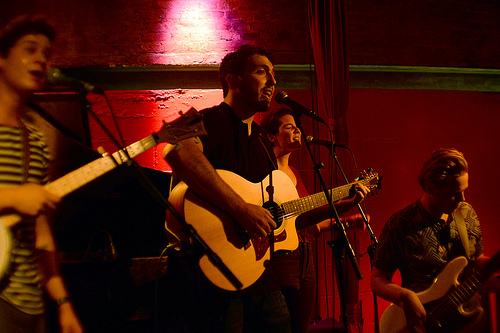

In [83]:
show('ILSVRC2017_test_00000009.JPEG')

In [84]:
resnet_preds['resnet_indices']

5499    [291, 286, 290, 288, 285, 179, 180, 281, 245, ...
5498    [655, 459, 831, 838, 721, 631, 774, 638, 697, ...
5497    [741, 982, 406, 399, 606, 854, 887, 564, 501, ...
5496    [1, 392, 0, 397, 393, 395, 973, 126, 389, 29, ...
5495    [867, 569, 803, 595, 517, 864, 561, 866, 856, ...
5494    [990, 957, 989, 301, 641, 952, 588, 954, 936, ...
5493    [40, 44, 42, 46, 41, 38, 43, 26, 47, 59, 31, 6...
5492    [459, 823, 711, 605, 837, 487, 785, 523, 836, ...
5491    [546, 402, 819, 420, 650, 776, 641, 401, 699, ...
5490    [83, 135, 85, 82, 21, 86, 80, 91, 8, 94, 7, 81...
Name: resnet_indices, dtype: object

In [85]:
resnet_preds['resnet_indices']

5499    [291, 286, 290, 288, 285, 179, 180, 281, 245, ...
5498    [655, 459, 831, 838, 721, 631, 774, 638, 697, ...
5497    [741, 982, 406, 399, 606, 854, 887, 564, 501, ...
5496    [1, 392, 0, 397, 393, 395, 973, 126, 389, 29, ...
5495    [867, 569, 803, 595, 517, 864, 561, 866, 856, ...
5494    [990, 957, 989, 301, 641, 952, 588, 954, 936, ...
5493    [40, 44, 42, 46, 41, 38, 43, 26, 47, 59, 31, 6...
5492    [459, 823, 711, 605, 837, 487, 785, 523, 836, ...
5491    [546, 402, 819, 420, 650, 776, 641, 401, 699, ...
5490    [83, 135, 85, 82, 21, 86, 80, 91, 8, 94, 7, 81...
Name: resnet_indices, dtype: object

In [86]:
np.where(resnet_preds['resnet_indices'].iloc[0] == 0)[0][0]

887

In [87]:
np.argmax(resnet_preds['resnet_percentage'].iloc[0])

291

In [88]:
resnet_preds['resnet_percentage'].iloc[0][291]

57.083775